In [10]:
import hashlib
import re
import requests
import json
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from html.parser import HTMLParser
from os import path
import matplotlib.pyplot as plt

In [3]:
# update me
url = "http://104.154.54.203/db_default/v4/nts/graph?highlight_run=145241&plot.1605785=1364.1605785.3"
filename = str(int(hashlib.sha256(url.encode('utf-8')).hexdigest()[:16],
                  16)-2**63) + ".txt"
print("cached filename:", filename)

if not path.exists(filename):
    payload = {}

    response = requests.request("GET", url, data=payload)

    with open(filename, "w") as f:
        f.write(response.text)


cached filename: -4690202479203809675.txt


In [4]:
class MyHTMLParser(HTMLParser):
    js_encountered = False

    def handle_starttag(self, tag, attrs):
        if tag != "script" or attrs != [('type', 'text/javascript')]:
            return
        self.js_encountered = True
        print("Encountered a start tag:", tag, attrs)

    def handle_endtag(self, tag):
        if not self.js_encountered:
            return
        print("Encountered an end tag :", tag)

    def handle_data(self, data):
        if not self.js_encountered:
            return
        self.js_encountered = False
        print("Encountered some data  :", data)
        print(data)
        print(data.index("graph_plots"))




In [23]:
def filter_by_date(points):
    one_month = date.today() - relativedelta(days=7)
    one_month = datetime.datetime(one_month.year, one_month.month, one_month.day)
    return [p for p in points if datetime.datetime.strptime(p[2]["date"], '%Y-%m-%d %H:%M:%S') > one_month]

In [38]:
with open(filename, "r") as f:
    # parser = MyHTMLParser()
    # parser.feed(f.read())
    for line in f:
        if "overview_plots" in line:
            line = line.strip()
            # print(line)
            values = re.findall(r'var.*?=\s*(.*?);', line, re.DOTALL |
                                re.MULTILINE)
            # print((values[0][:10]))
            points = json.loads(values[0])
            points = points[0]["data"]  # a list of data points

            points = filter_by_date(points)
            
            # convert string dates to manipulatable datetimes
            for p in points:
                p[2]["date"] = datetime.datetime.strptime(p[2]["date"], '%Y-%m-%d %H:%M:%S')
            
            print(points[0])
            print(points[1])
            print(points[2])
            print("...", len(points), "points found ...")
            break

[250, 16.5498, {'date': datetime.datetime(2021, 5, 19, 5, 1, 59), 'label': '0c509dbc7e29cbd03f161513b8d335f768c7cc2b', 'runID': '145415'}]
[278, 16.6249, {'date': datetime.datetime(2021, 5, 20, 19, 53, 31), 'label': '0af3105b641a8506e29218d9c86d020811a60289', 'runID': '145513'}]
[712, 16.7474, {'date': datetime.datetime(2021, 5, 19, 10, 25, 25), 'label': 'c1dc267258e06bb69e1ca217d1d8ce2d15b8757f', 'runID': '145428'}]
... 73 points found ...


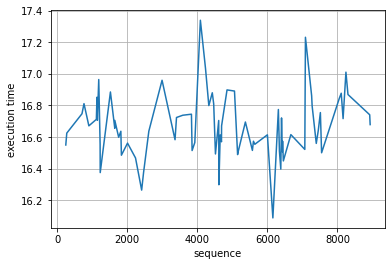

In [39]:
xs = [p[0] for p in points]
ys = [p[1] for p in points]

fig, axs = plt.subplots(1, 1)
axs.plot(xs, ys)
axs.set_xlabel('sequence')
axs.set_ylabel('execution time')
axs.grid(True)

plt.show()

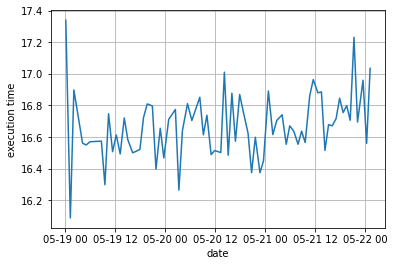

In [40]:
points.sort(key=lambda p: p[2]["date"])
dates = [p[2]["date"] for p in points]
ys = [p[1] for p in points]

fig, axs = plt.subplots(1, 1)
axs.plot(dates, ys)
axs.set_xlabel('date')
axs.set_ylabel('execution time')
axs.grid(True)

plt.show()